# CNTK 206 B: Deep Convolutional GAN with MNIST data

**Prerequisites**: We assume that you have successfully downloaded the MNIST data by completing the tutorial titled CNTK_103A_MNIST_DataLoader.ipynb.

## Introduction

[Generative models](https://en.wikipedia.org/wiki/Generative_model) have gained a [lot of attention](https://openai.com/blog/generative-models/) in deep learning community which has traditionally leveraged [discriminative models](https://en.wikipedia.org/wiki/Discriminative_model) for (semi-supervised) and unsupervised learning. 

## Overview
In the previous tutorial we introduce the original GAN implementation by [Goodfellow et al](https://arxiv.org/pdf/1406.2661v1.pdf) at NIPS  2014. This pioneering work has since then been extended and many techniques have been published amongst which the Deep Convolutional Generative Adversarial Network a.k.a. DCGAN has become the recommended launch pad in the community.

In this tutorial, we introduce an implementation of the DCGAN with some well tested architectural constraints that improve stability in the GAN training: 

- We use strided convolutions in the (discriminator) and fractional-strided convolutions in the generator.
- We have used batch normalization in both the generator and the discriminator
- We have removed fully connected hidden layers for deeper architectures.
- We use ReLU activation in generator for all layers except for the output, which uses Tanh.
- We use LeakyReLU activation in the discriminator for all layers.


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os

import cntk as C
from cntk import Trainer
from cntk.layers import default_options, Input
from cntk.device import set_default_device, gpu, cpu
from cntk.initializer import normal
from cntk.io import (MinibatchSource, CTFDeserializer, StreamDef, StreamDefs,
                     INFINITELY_REPEAT, FULL_DATA_SWEEP)
from cntk.layers import Dense, Convolution2D, ConvolutionTranspose2D, BatchNormalization
from cntk.learner import (adam, UnitType, sgd, learning_rate_schedule,
                          momentum_as_time_constant_schedule, momentum_schedule)
from cntk.utils.progress_print import ProgressPrinter

%matplotlib inline

### Select the notebook runtime environment devices / settings

Set the device to cpu / gpu for the test environment. If you have both CPU and GPU on your machine, you can optionally switch the devices. By default, we choose the best available device.

In [2]:
# Select the right target device when this notebook is being tested:
if 'TEST_DEVICE' in os.environ:
    import cntk
    if os.environ['TEST_DEVICE'] == 'cpu':
        C.device.set_default_device(C.device.cpu())
    else:
        C.device.set_default_device(C.device.gpu(0))
C.device.set_default_device(C.device.gpu(0))

There are two run modes:
- *Fast mode*: `isFast` is set to `True`. This is the default mode for the notebooks, which means we train for fewer iterations or train / test on limited data. This ensures functional correctness of the notebook though the models produced are far from what a completed training would produce.

- *Slow mode*: We recommend the user to set this flag to `False` once the user has gained familiarity with the notebook content and wants to gain insight from running the notebooks for a longer period with different parameters for training. 

**Note**
If the `isFlag` is set to `False` the notebook will take a few hours on a GPU enabled machine. You can try fewer iterations by setting the `num_minibatches` to a smaller number say `20,000` which comes at the expense of quality of the generated images.

In [3]:
isFast = True

## Data Reading
The input to the GAN will be a vector of random numbers. At the end of the traning, the GAN "learns" to generate images of hand written digits drawn from the [MNIST database](https://en.wikipedia.org/wiki/MNIST_database). We will be using the same MNIST data generated in tutorial 103A.  A more in-depth discussion of the data format and reading methods can be seen in previous tutorials.  For our purposes, just know that the following function returns an object that will be used to generate images from the MNIST dataset.  Since we are building an unsupervised model, we only need to read in `features` and ignore the `labels`.

In [4]:
# Ensure the training data is generated and available for this tutorial
# We search in two locations in the toolkit for the cached MNIST data set.

data_found = False
for data_dir in [os.path.join("..", "Examples", "Image", "DataSets", "MNIST"),
                 os.path.join("data", "MNIST")]:
    train_file = os.path.join(data_dir, "Train-28x28_cntk_text.txt")
    if os.path.isfile(train_file):
        data_found = True
        break
        
if not data_found:
    raise ValueError("Please generate the data by completing CNTK 103 Part A")
    
print("Data directory is {0}".format(data_dir))

Data directory is data\MNIST


In [5]:
def create_reader(path, is_training, input_dim, label_dim):
    deserializer = CTFDeserializer(
        filename = path,
        streams = StreamDefs(
            labels_unused = StreamDef(field = 'labels', shape = label_dim, is_sparse = False),
            features = StreamDef(field = 'features', shape = input_dim, is_sparse = False
            )
        )
    )
    return MinibatchSource(
        deserializers = deserializer,
        randomize = is_training,
        epoch_size = INFINITELY_REPEAT if is_training else FULL_DATA_SWEEP
    )

The random noise we will use to train the GAN is provided by the `noise_sample` function to generate random noise samples from a uniform distribution within the interval [-1, 1].

In [6]:
np.random.seed(123)
def noise_sample(num_samples):
    return np.random.uniform(
        low = -1.0,
        high = 1.0,
        size = [num_samples, g_input_dim]
    ).astype(np.float32)

## Model Creation

First we provide a brief recap of the basics of GAN. You may skip this block if you are familiar with CNTK 206A. 

A GAN network is composed of two sub-networks, one called the Generator ($G$) and the other Discriminator ($D$). 
- The **Generator** takes random noise vector ($z$) as input and strives to output synthetic (fake) image ($x^*$) that is indistinguishable from the real image ($x$) from the MNIST dataset. 
- The **Discriminator** strives to differentiate between the real image ($x$) and the fake ($x^*$) image.

<img src = "https://www.cntk.ai/jup/GAN_basic_flow.png">

In each training iteration, the Generator produces more realistic fake images (in other words *minimizes* the difference between the real and generated counterpart) and the Discriminator *maximizes* the probability of assigning the correct label (real vs. fake) to both real examples (from training set) and the generated fake ones. The two conflicting objectives between the sub-networks ($G$ and $D$) leads to the GAN network (when trained) converge to an equilibrium, where the Generator produces realistic looking fake MNIST images and the Discriminator can at best randomly guess whether images are real or fake. The resulting Generator model once trained produces realistic MNIST image with the input being a random number. 

### Model config

First, we establish some of the architectural and training hyper-parameters for our model.  

- The generator network is fractional strided convolutional network.  The input is a 10-dimensional random vector and the output of the generator is a flattened version of a 28 x 28 fake image. The discriminator is strided-convolution network.  It takes as input the 784 dimensional output of the generator or a real MNIST image, reshapes into a 28 x 28 image format and outputs a single scalar - the estimated probability that the input image is a real MNIST image.

### Model components
We build a computational graph for our model, one each for the generator and the discriminator. First, we establish some of the architectural parameters of our model. 

In [7]:
# architectural parameters
img_h, img_w = 28, 28
kernel_h, kernel_w = 5, 5 
stride_h, stride_w = 2, 2

# Input / Output parameter of Generator and Discriminator
g_input_dim = 100
g_output_dim = d_input_dim = img_h * img_w

# We expect the kernel shapes to be square in this tutorial and
# the strides to be of the same length along each data dimension
if kernel_h == kernel_w:
    gkernel = dkernel = kernel_h
else:
    raise ValueError('This tutorial needs square shaped kernel') 
            
if stride_h == stride_w:
    gstride = dstride = stride_h
else:
    raise ValueError('This tutorial needs same stride in all dims')

In [8]:
# Helper functions
def bn_with_relu(x, activation=C.relu):
    h = BatchNormalization(map_rank=1)(x)
    return C.relu(h)

# We use param-relu function to use a leak=0.2 since CNTK implementation 
# of Leaky ReLU is fixed to 0.01
def bn_with_leaky_relu(x, leak=0.2):
    h = BatchNormalization(map_rank=1)(x)
    r = C.param_relu(C.constant((np.ones(h.shape)*leak).astype(np.float32)), h)
    return r

**Generator**

The generator takes a 100-dimensional random vector (for starters) as input ($z$) and the outputs a 784 dimensional vector, corresponding to a flattened version of a 28 x 28 fake (synthetic) image ($x^*$). In this tutorial, we use fractionally strided convolutions (a.k.a ConvolutionTranspose) with ReLU activations except for the last layer. We use a tanh activation on the last layer to make sure that the output of the generator function is confined to the interval [-1, 1]. The use of ReLU and tanh activation functions are key in addition to using the fractionally strided convolutions.

In [9]:
def convolutional_generator(z):
    with default_options(init=C.normal(scale=0.02)):
        print('Generator input shape: ', z.shape)

        s_h2, s_w2 = img_h//2, img_w//2 #Input shape (14,14)
        s_h4, s_w4 = img_h//4, img_w//4 # Input shape (7,7)
        gfc_dim = 1024
        gf_dim = 64

        h0 = Dense(gfc_dim, activation=None)(z)
        h0 = bn_with_relu(h0)
        print('h0 shape', h0.shape)

        h1 = Dense([gf_dim * 2, s_h4,  s_w4], activation=None)(h0)
        h1 = bn_with_relu(h1)
        print('h1 shape', h1.shape)

        h2 = ConvolutionTranspose2D(gkernel,
                                  num_filters=gf_dim*2,
                                  strides=gstride,
                                  pad=True,
                                  output_shape=(s_h2, s_w2),
                                  activation=None)(h1)
        h2 = bn_with_relu(h2)
        print('h2 shape', h2.shape)

        h3 = ConvolutionTranspose2D(gkernel,
                                  num_filters=1,
                                  strides=gstride,
                                  pad=True,
                                  output_shape=(img_h, img_w),
                                  activation=C.sigmoid)(h2)
        print('h3 shape :', h3.shape)

        return C.reshape(h3, img_h * img_w)

**Discriminator**

The discriminator takes as input ($x^*$) the 784 dimensional output of the generator or a real MNIST image, re-shapes the input to a 28 x 28 image and outputs the estimated probability that the input image is a real MNIST image. The network is modeled using strided convolution with Leaky ReLU activation except for the last layer. We use a sigmoid activation on the last layer to ensure the discriminator output lies in the inteval of [0,1].

In [10]:
def convolutional_discriminator(x):
    with default_options(init=C.normal(scale=0.02)):

        dfc_dim = 1024
        df_dim = 64

        print('Discriminator convolution input shape', x.shape)
        x = C.reshape(x, (1, img_h, img_w))

        h0 = Convolution2D(dkernel, 1, strides=dstride)(x)
        h0 = bn_with_leaky_relu(h0, leak=0.2)
        print('h0 shape :', h0.shape)

        h1 = Convolution2D(dkernel, df_dim, strides=dstride)(h0)
        h1 = bn_with_leaky_relu(h1, leak=0.2)
        print('h1 shape :', h1.shape)

        h2 = Dense(dfc_dim, activation=None)(h1)
        h2 = bn_with_leaky_relu(h2, leak=0.2)
        print('h2 shape :', h2.shape)

        h3 = Dense(1, activation=C.sigmoid)(h2)
        print('h3 shape :', h3.shape)

        return h3

We use a minibatch size of 128 and a fixed learning rate of 0.0002 for training. In the fast mode (`isFast = True`)  we verify only functional correctness with 5000 iterations. 

**Note**: In the slow mode, the results look a lot better but it requires in the order of 10 minutes depending on your hardware. In general, the more number of minibatches one trains, the better is the fidelity of the generated images.

In [11]:
# training config
minibatch_size = 128
num_minibatches = 5000 if isFast else 10000
lr = 0.0002
momentum = 0.5 #equivalent to beta1

### Build the graph

The rest of the computational graph is mostly responsible for coordinating the training algorithms and parameter updates, which is particularly tricky with GANs for couple reasons. The GANs are sensitive to the choice of learner and the parameters. Many of the parameters chosen here are based on many hard learnt lessons from the community. You may directly go to the code if you have read the basic GAN tutorial. 

- First, the discriminator must be used on both the real MNIST images and fake images generated by the generator function.  One way to represent this in the computational graph is to create a clone of the output of the discriminator function, but with substituted inputs.  Setting `method=share` in the `clone` function ensures that  both paths through the discriminator model use the same set of parameters.


- Second, we need to update the parameters for the generator and discriminator model separately using the gradients from different loss functions.  We can get the parameters for a `Function` in the graph with the `parameters` attribute.  However, when updating the model parameters, update only the parameters of the respective models while keeping the other parameters unchanged. In other words, when updating the generator we will update only the parameters of the $G$ function while keeping the parameters of the $D$ function fixed and vice versa.

### Training the Model
The code for training the GAN very closely follows the algorithm as presented in the [original NIPS 2014 paper](https://arxiv.org/pdf/1406.2661v1.pdf). In this implementation, we train $D$ to maximize the probability of assigning the correct label (fake vs. real) to both training examples and the samples from $G$. In other words, $D$ and $G$ play the following two-player minimax game with the value function $V(G,D)$:

$$
    \min_G \max_D V(D,G)= \mathbb{E}_{x}[ log D(x) ] + \mathbb{E}_{z}[ log(1 - D(G(z))) ]
$$

At the optimal point of this game the generator will produce realistic looking data while the discriminator will predict that the generated image is indeed fake with a probability of 0.5. The [algorithm referred below](https://arxiv.org/pdf/1406.2661v1.pdf) is implemented in this tutorial.


<img src = "https://www.cntk.ai/jup/GAN_goodfellow_NIPS2014.png", width = 500>

In [12]:
def build_graph(noise_shape, image_shape, generator, discriminator):
    input_dynamic_axes = [C.Axis.default_batch_axis()]
    Z = Input(noise_shape, dynamic_axes=input_dynamic_axes)
    X_real = Input(image_shape, dynamic_axes=input_dynamic_axes)
    X_real_scaled = X_real / 255.0

    # Create the model function for the generator and discriminator models
    X_fake = generator(Z)
    D_real = discriminator(X_real_scaled)
    D_fake = D_real.clone(
        method = 'share',
        substitutions = {X_real_scaled.output: X_fake.output}
    )

    # Create loss functions and configure optimazation algorithms
    G_loss = 1.0 - C.log(D_fake)
    D_loss = -(C.log(D_real) + C.log(1.0 - D_fake))

    G_learner = adam(
        parameters = X_fake.parameters,
        lr = learning_rate_schedule(lr, UnitType.sample),
        momentum = momentum_schedule(0.5)
    )
    D_learner = adam(
        parameters = D_real.parameters,
        lr = learning_rate_schedule(lr, UnitType.sample),
        momentum = momentum_schedule(0.5)
    )

    # Instantiate the trainers
    G_trainer = Trainer(
        X_fake,
        (G_loss, None),
        G_learner
    )
    D_trainer = Trainer(
        D_real,
        (D_loss, None),
        D_learner
    )

    return X_real, X_fake, Z, G_trainer, D_trainer

With the value functions defined we proceed to interatively train the GAN model. The training of the model can take significnantly long depending on the hardware especiallly if `isFast` flag is turned off.

In [13]:
def train(reader_train, generator, discriminator):
    X_real, X_fake, Z, G_trainer, D_trainer = \
        build_graph(g_input_dim, d_input_dim, generator, discriminator)

    # print out loss for each model for upto 25 times
    print_frequency_mbsize = num_minibatches // 25
   
    print("First row is Generator loss, second row is Discriminator loss")
    pp_G = ProgressPrinter(print_frequency_mbsize)
    pp_D = ProgressPrinter(print_frequency_mbsize)

    k = 2

    input_map = {X_real: reader_train.streams.features}
    for train_step in range(num_minibatches):

        # train the discriminator model for k steps
        for gen_train_step in range(k):
            Z_data = noise_sample(minibatch_size)
            X_data = reader_train.next_minibatch(minibatch_size, input_map)
            if X_data[X_real].num_samples == Z_data.shape[0]:
                batch_inputs = {X_real: X_data[X_real].value, Z: Z_data}
                D_trainer.train_minibatch(batch_inputs)

        # train the generator model for a single step
        Z_data = noise_sample(minibatch_size)
        batch_inputs = {Z: Z_data}

        G_trainer.train_minibatch(batch_inputs)
        G_trainer.train_minibatch(batch_inputs)

        pp_G.update_with_trainer(G_trainer)
        pp_D.update_with_trainer(D_trainer)

        G_trainer_loss = C.utils.get_train_loss(G_trainer)

    return Z, X_fake, G_trainer_loss

In [14]:
reader_train = create_reader(train_file, True, d_input_dim, label_dim=10)

# G_input, G_output, G_trainer_loss = train(reader_train, dense_generator, dense_discriminator)
G_input, G_output, G_trainer_loss = train(reader_train,
                                          convolutional_generator,
                                          convolutional_discriminator)

Generator input shape:  (100,)
h0 shape (1024,)
h1 shape (128, 7, 7)
h2 shape (128, 14, 14)
h3 shape : (1, 28, 28)
Discriminator convolution input shape (784,)
h0 shape : (1, 12, 12)
h1 shape : (64, 4, 4)
h2 shape : (1024,)
h3 shape : (1,)
First row is Generator loss, second row is Discriminator loss
 Minibatch[   1- 200]: loss = 3.106364 * 25600;
 Minibatch[   1- 200]: loss = 0.522517 * 25600;
 Minibatch[ 201- 400]: loss = 3.246154 * 25600;
 Minibatch[ 201- 400]: loss = 0.501793 * 25600;
 Minibatch[ 401- 600]: loss = 2.842856 * 25600;
 Minibatch[ 401- 600]: loss = 0.609516 * 25600;
 Minibatch[ 601- 800]: loss = 2.787515 * 25600;
 Minibatch[ 601- 800]: loss = 0.605799 * 25600;
 Minibatch[ 801-1000]: loss = 2.695768 * 25600;
 Minibatch[ 801-1000]: loss = 0.643665 * 25600;
 Minibatch[1001-1200]: loss = 2.543803 * 25600;
 Minibatch[1001-1200]: loss = 0.685593 * 25600;
 Minibatch[1201-1400]: loss = 2.563904 * 25600;
 Minibatch[1201-1400]: loss = 0.619889 * 25600;
 Minibatch[1401-1600]: los

In [15]:
# Print the generator loss 
print("Training loss of the generator is: {0:.2f}".format(G_trainer_loss))

Training loss of the generator is: 1.73


## Generating Fake (Synthetic) Images

Now that we have trained the model, we can create fake images simply by feeding random noise into the generator and displaying the outputs.  Below are a few images generated from random samples.  To get a new set of samples, you can re-run the last cell.

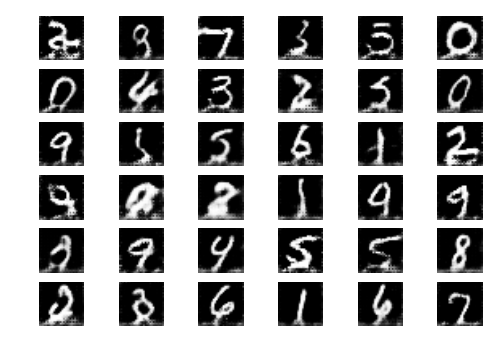

In [16]:
def plot_images(images, subplot_shape):
    plt.style.use('ggplot')
    fig, axes = plt.subplots(*subplot_shape)
    for image, ax in zip(images, axes.flatten()):
        ax.imshow(image.reshape(28, 28), vmin=0, vmax=1.0, cmap='gray')
        ax.axis('off')
    plt.show()


noise = noise_sample(36)
images = G_output.eval({G_input: noise})
plot_images(images, subplot_shape=[6, 6])

Larger number of iterations should generate more realistic looking MNIST images. A sampling of such generated images are shown below.

<img src="http://www.cntk.ai/jup/cntk206B_dcgan_result.jpg">

**Note**: It takes a large number of iterations to capture a representation of the real world signal. Even simple dense networks can be quite effective in modelling data albeit MNIST is a relatively simple dataset as well.

**Suggested Task**

- Please refer to several hacks presented in this [article](https://github.com/soumith/ganhacks) by Soumith Chintala, Facebook Research. While some of the hacks have been incorporated in this notebook, there are several others I would suggest that you try out.

- Performance is a key aspect to deep neural networks training. Study how the changing the minibatch sizes impact the performance both with regards to quality of the generated images and the time it takes to train a model.

- Try generating fake images using the CIFAR-10 data set as the training data. How does the network above performs? There are other variation in GAN, such as [conditional GAN](https://arxiv.org/pdf/1411.1784.pdf) where the network is additionally conditioned on the input label. Try implementing the labels.
